<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5,6,7,8,9
A,b,.,1,a,.,a,.,a,a,.
B,.,.,a,.,a,.,.,a,a,.
C,1,.,a,b,.,.,.,.,.,a
D,.,a,.,.,.,.,b,.,.,.
E,.,a,.,.,b,.,.,.,a,a
F,1,.,.,.,1,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,1,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,1,.,c,.,.



Turno: 0 Puntos:-61
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,a,.,a,.,a,a,.
B,.,.,a,.,a,.,.,a,a,.
C,1,.,a,b,.,.,.,.,.,a
D,.,a,.,.,.,.,b,.,.,.
E,.,a,.,.,b,.,.,.,a,a
F,1,.,.,.,1,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,1,.,c,.,.



Turno: 1 Puntos:-20
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,a,.,a,.,a,a,.
B,1,.,a,.,a,.,.,a,a,.
C,.,.,a,b,.,.,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,1,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,1,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,.,1,c,.,.



Turno: 2 Puntos:-17
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,a,.,a,.,a,a,.
B,.,1,.,.,a,.,.,a,a,.
C,.,b,.,b,.,.,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,1,.,.,b,1,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,1,.,c,.,.



Turno: 3 Puntos:-14
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,.,.,a,.,a,a,.
B,.,.,1,b,.,.,.,a,a,.
C,.,b,.,b,.,.,.,.,.,a
D,b,1,.,.,.,1,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,.,1,c,.,.



Turno: 4 Puntos:-11
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,.,.,a,.,a,a,.
B,.,.,1,b,.,.,.,a,a,.
C,.,b,.,b,.,.,.,.,.,a
D,b,.,.,.,.,1,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,.,1,c,.,.



Turno: 5 Puntos:14
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,.,.,a,.,a,a,.
B,.,.,.,b,.,a,.,a,a,.
C,.,b,1,b,.,1,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,1,.,c,.,.



Turno: 6 Puntos:15
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,.,.,a,.,a,a,.
B,.,c,1,b,.,a,.,a,a,.
C,.,b,.,b,.,.,1,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,.,1,c,.,.



Turno: 7 Puntos:40
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,.,.,.,.,a,a,.
B,.,c,.,1,c,.,1,a,a,.
C,.,b,.,.,.,.,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,1,.,c,.,.



Turno: 8 Puntos:53
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,1,a,.,1,a,a,.
B,.,c,.,.,c,.,.,a,a,.
C,.,b,.,.,.,.,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,.,1,c,.,.



Turno: 9 Puntos:54
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,.,a,a,.
B,.,c,.,a,c,.,1,a,a,.
C,.,b,.,.,.,.,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,1,.,c,.,.



Turno: 10 Puntos:75
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,1,a,a,.
B,.,c,.,a,c,.,.,a,a,.
C,.,b,.,.,.,.,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,.,1,c,.,.



Turno: 11 Puntos:76
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,1,a,a,.
C,.,b,.,.,.,.,.,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,.,1,x,c,.,.



Turno: 12 Puntos:-21
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,1,a,a,.
C,.,b,.,.,.,.,1,.,.,a
D,b,.,.,.,.,.,b,.,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,.,a,b,a,.,b
J,.,.,.,a,1,x,x,c,.,.



Turno: 13 Puntos:-96
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,1,a,a,.
C,.,b,.,.,.,.,.,1,.,a
D,b,.,.,.,.,.,b,a,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,.,a,2,b,a,a
I,.,.,.,.,1,a,b,a,.,b
J,.,.,.,a,x,x,x,c,.,.



Turno: 14 Puntos:-145
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,1,a
D,b,.,.,.,.,.,b,a,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,1,a,2,b,a,a
I,.,.,.,.,x,a,b,a,.,b
J,.,.,.,a,x,x,x,c,.,.



Turno: 15 Puntos:-174
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,.,a
D,b,.,.,.,.,.,b,a,1,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,1,1,a,2,b,a,a
I,.,.,.,.,x,a,b,a,.,b
J,.,.,.,a,x,x,x,c,.,.



Turno: 16 Puntos:-199
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,1,a
D,b,.,.,.,.,.,b,a,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,.,1,a,2,b,a,a
I,.,.,.,1,x,a,b,a,.,b
J,.,.,a,a,x,x,x,c,.,.



Turno: 17 Puntos:-198
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,.,a
D,b,.,.,.,.,.,b,a,1,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,1,x,a,2,b,a,a
I,.,a,1,.,x,a,b,a,.,b
J,.,.,a,a,x,x,x,c,.,.



Turno: 18 Puntos:-247
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,1,a
D,b,.,.,.,.,.,b,a,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,.,a,.,b,x,a,b,a,.,b
J,.,.,1,.,x,x,x,c,.,.



Turno: 19 Puntos:-224
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,.,a
D,b,.,.,.,.,.,b,a,1,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,.,a,1,b,x,a,b,a,.,b
J,.,a,.,.,x,x,x,c,.,.



Turno: 20 Puntos:-223
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,1,a
D,b,.,.,.,.,.,b,a,.,.
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,.,a,.,b,x,a,b,a,.,b
J,.,a,1,a,x,x,x,c,.,.



Turno: 21 Puntos:-222
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,.,a
D,b,.,.,.,.,.,b,a,1,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,.,a,1,b,x,a,b,a,.,b
J,.,a,.,a,x,x,x,c,.,.



Turno: 22 Puntos:-217
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,1,a
D,b,.,.,.,.,.,b,a,.,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,.,.,.,b,x,a,b,a,.,b
J,b,.,1,a,x,x,x,c,.,.



Turno: 23 Puntos:-214
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,x,a
D,b,.,.,.,.,.,b,a,1,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,.,a,1,b,x,a,b,a,.,b
J,b,.,.,a,x,x,x,c,.,.



Turno: 24 Puntos:-263
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,x,a
D,b,.,.,.,.,.,b,a,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,.,a,.,b,x,a,b,a,.,b
J,b,a,1,a,x,x,x,c,.,.



Turno: 25 Puntos:-242
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,x,a
D,b,.,.,.,.,.,b,a,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,1,b,x,a,b,a,.,b
J,b,.,.,a,x,x,x,c,.,.



Turno: 26 Puntos:-239
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,x,a
D,b,.,.,.,.,.,b,a,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,1,a,x,x,x,c,.,.



Turno: 27 Puntos:-288
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,.,a,.,x,a
D,b,.,.,.,.,.,b,a,2,b
E,.,.,.,.,b,1,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 28 Puntos:-293
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,.,a,a,.,x,a
D,b,.,.,.,.,1,b,a,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 29 Puntos:-292
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,b,1,.,.,x,a
D,b,.,.,.,.,.,b,a,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 30 Puntos:-289
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,b,.,1,.,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 31 Puntos:-288
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,b,a,.,1,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 32 Puntos:-287
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,a,.
B,.,c,.,a,c,b,2,a,a,.
C,.,b,.,.,b,a,1,.,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,.,b,.,1,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 33 Puntos:-312
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,b,a,2,b,x,a
D,b,.,.,.,.,a,b,.,2,b
E,.,.,.,.,b,.,.,1,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 34 Puntos:-292
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,1,2,b
E,.,.,.,.,.,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 35 Puntos:-279
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,.,2,b
E,.,.,.,.,.,a,.,1,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 36 Puntos:-278
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,1,2,b
E,.,.,.,.,.,a,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 37 Puntos:-277
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,.,2,b
E,.,.,.,.,b,.,.,1,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,.,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 38 Puntos:-274
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,1,2,b
E,.,.,.,.,b,.,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,2,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 39 Puntos:-279
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,.,2,b
E,.,.,.,.,b,a,.,1,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,2,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 40 Puntos:-278
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,.,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,1,2,b
E,.,.,.,.,b,a,.,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,2,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 41 Puntos:-277
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,.,2,b
E,.,.,.,.,b,a,.,1,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,2,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 42 Puntos:-276
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,.,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,a,2,b
E,.,.,.,.,b,a,1,.,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,2,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 43 Puntos:-275
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,a,2,b
E,.,.,.,.,b,a,x,1,a,a
F,.,.,.,.,.,.,a,a,a,.
G,.,.,a,a,a,.,a,2,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 44 Puntos:-324
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,a,2,b
E,.,.,.,.,b,a,x,2,a,a
F,.,.,.,.,b,.,a,a,a,.
G,.,.,a,a,a,.,a,2,a,.
H,.,.,a,2,x,a,2,b,a,a
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 45 Puntos:-299
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,a,2,b
E,.,.,.,.,.,.,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 46 Puntos:-295
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,a,2,b
E,.,.,.,.,a,.,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 47 Puntos:-294
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,a,2,b
E,.,.,.,.,a,a,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 48 Puntos:-293
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,a,2,b
E,.,.,.,.,a,a,x,2,.,.
F,.,.,.,.,1,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 49 Puntos:-318
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,.,b,a,2,b
E,.,.,.,b,1,.,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 50 Puntos:-315
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,a,2,b
E,.,.,.,b,.,1,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 51 Puntos:-314
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,c,b,2,a,.,.
C,.,b,.,.,.,.,2,b,x,a
D,b,.,.,.,c,a,b,a,2,b
E,.,.,.,b,1,1,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 52 Puntos:-339
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,.,b,2,a,.,.
C,.,b,.,.,d,.,2,b,x,a
D,b,.,.,.,1,a,b,a,2,b
E,.,.,.,b,.,1,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 53 Puntos:-264
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,.,b,2,a,.,.
C,.,b,.,.,d,.,2,b,x,a
D,b,.,.,1,.,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 54 Puntos:-243
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,.,a,.,b,2,a,.,.
C,.,b,a,1,d,.,2,b,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 55 Puntos:-242
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,.,.,x,a,.,.
B,.,c,b,1,.,b,2,a,.,.
C,.,b,.,.,d,.,2,b,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 56 Puntos:-239
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,.,1,b,2,a,.,.
C,.,b,.,.,d,.,2,b,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 57 Puntos:-238
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,1,.,b,2,a,.,.
C,.,b,.,a,d,.,2,b,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 58 Puntos:-237
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,.,1,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 59 Puntos:-236
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,1,.,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,.,.,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 60 Puntos:-235
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,.,1,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,.,b,a,b,a,2,b
E,.,.,.,b,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 61 Puntos:-230
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,1,.,b,2,a,.,.
C,.,b,.,.,d,a,2,b,x,a
D,b,.,.,c,.,a,b,a,2,b
E,.,.,.,.,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 62 Puntos:-217
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,1,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,.,a,b,a,2,b
E,.,.,.,.,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,a,a,a,.,.,2,.,.
H,.,.,a,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 63 Puntos:-266
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,.,a,b,a,2,b
E,.,.,.,.,.,2,x,2,.,.
F,.,.,.,.,b,c,.,.,.,.
G,.,.,.,.,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 64 Puntos:-246
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,.,a,b,a,2,b
E,.,.,.,.,b,2,x,2,.,.
F,.,.,.,.,b,c,.,.,.,.
G,.,.,.,.,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 65 Puntos:-241
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,.,.,.,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,.,.,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 66 Puntos:-226
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,.,.,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,.,.,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 67 Puntos:-225
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,.,.,a,2,x,2,.,.
F,.,.,.,.,1,c,.,.,.,.
G,.,.,.,.,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 68 Puntos:-250
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,.,.,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,.,a,1,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 69 Puntos:-249
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,.,.,a,2,x,2,.,.
F,.,.,.,1,1,c,.,.,.,.
G,.,.,.,a,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 70 Puntos:-274
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,1,1,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,.,a,1,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 71 Puntos:-299
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,1,c,c,a,b,a,2,b
E,.,.,.,.,a,2,x,2,.,.
F,.,.,.,1,1,c,.,.,.,.
G,.,.,.,a,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 72 Puntos:-298
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,a,1,1,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,.,a,1,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 73 Puntos:-297
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,a,1,c,c,a,b,a,2,b
E,.,a,.,.,a,2,x,2,.,.
F,.,.,.,1,1,c,.,.,.,.
G,.,.,.,a,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 74 Puntos:-296
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,1,.,c,c,a,b,a,2,b
E,.,.,b,1,a,2,x,2,.,.
F,.,.,.,.,.,c,.,.,.,.
G,.,.,.,a,1,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 75 Puntos:-293
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,1,c,c,a,b,a,2,b
E,.,.,b,.,a,2,x,2,.,.
F,.,.,1,1,1,c,.,.,.,.
G,.,.,.,a,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 76 Puntos:-318
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,a,2,c,c,a,b,a,2,b
E,.,.,b,1,a,2,x,2,.,.
F,.,.,.,1,.,c,.,.,.,.
G,.,.,.,a,1,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 77 Puntos:-297
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,a,2,c,c,a,b,a,2,b
E,.,.,b,1,a,2,x,2,.,.
F,.,a,1,.,1,c,.,.,.,.
G,.,.,.,a,.,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 78 Puntos:-296
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,a,2,c,c,a,b,a,2,b
E,.,.,b,2,a,2,x,2,.,.
F,.,a,.,c,x,c,.,.,.,.
G,.,.,1,a,1,.,.,2,.,.
H,.,.,.,2,x,a,2,b,.,.
I,b,.,x,b,x,a,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 79 Puntos:-301
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,a,2,c,c,a,b,a,2,b
E,.,.,b,2,a,2,x,2,.,.
F,.,a,1,c,x,c,.,.,.,.
G,.,.,.,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 80 Puntos:-278
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,a,2,c,c,a,b,a,2,b
E,.,.,b,2,a,2,x,2,.,.
F,.,a,.,c,x,c,.,.,.,.
G,.,1,1,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 81 Puntos:-303
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,2,c,c,a,b,a,2,b
E,.,b,b,2,a,2,x,2,.,.
F,.,1,1,c,x,c,.,.,.,.
G,.,.,.,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 82 Puntos:-300
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,2,c,c,a,b,a,2,b
E,.,b,b,2,a,2,x,2,.,.
F,.,.,1,c,x,c,.,.,.,.
G,.,a,1,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 83 Puntos:-299
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,2,c,c,a,b,a,2,b
E,.,b,b,2,a,2,x,2,.,.
F,.,.,.,c,x,c,.,.,.,.
G,.,a,1,a,2,b,.,2,.,.
H,.,a,1,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 84 Puntos:-298
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,2,c,c,a,b,a,2,b
E,.,.,.,2,a,2,x,2,.,.
F,.,c,1,c,x,c,.,.,.,.
G,.,.,.,a,2,b,.,2,.,.
H,.,1,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 85 Puntos:-285
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,2,c,c,a,b,a,2,b
E,.,a,1,2,a,2,x,2,.,.
F,.,c,.,c,x,c,.,.,.,.
G,.,1,.,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 86 Puntos:-284
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,a,.,3,a,2,x,2,.,.
F,.,c,a,c,x,c,.,.,.,.
G,.,x,1,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 87 Puntos:-248
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,2,.,.
F,.,c,1,c,x,c,.,.,.,.
G,.,x,x,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 88 Puntos:-295
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,2,.,.
F,.,c,2,c,x,c,1,.,.,.
G,.,x,x,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 89 Puntos:-300
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,2,.,.
F,.,c,2,c,x,c,.,1,a,.
G,.,x,x,a,2,b,.,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 90 Puntos:-299
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,2,.,.
F,.,c,2,c,x,c,1,.,a,.
G,.,x,x,a,2,b,a,2,.,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 91 Puntos:-298
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,2,.,.
F,.,c,2,c,x,c,.,1,a,.
G,.,x,x,a,2,b,a,2,1,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 92 Puntos:-323
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,a,.,a,.
G,.,x,x,a,2,b,a,.,1,.
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 93 Puntos:-237
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,a,.,a,b
G,.,x,x,a,2,b,a,.,.,1
H,.,.,.,2,x,.,2,b,.,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 94 Puntos:-232
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,a,.,a,b
G,.,x,x,a,2,b,a,.,.,.
H,.,.,.,2,x,.,2,b,a,1
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 95 Puntos:-231
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,a,.,a,b
G,.,x,x,a,2,b,a,.,1,1
H,.,.,.,2,x,.,2,b,a,.
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 96 Puntos:-256
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,a,.,a,b
G,.,x,x,a,2,b,a,1,.,1
H,.,.,.,2,x,.,2,b,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 97 Puntos:-255
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,a,1,a,b
G,.,x,x,a,2,b,a,.,b,2
H,.,.,.,2,x,.,2,b,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 98 Puntos:-230
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,1,.,a,b
G,.,x,x,a,2,b,.,c,.,2
H,.,.,.,2,x,.,2,.,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 99 Puntos:-217
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,.,1,a,b
G,.,x,x,a,2,b,a,c,.,2
H,.,.,.,2,x,.,2,.,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 100 Puntos:-216
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,.,.
F,.,c,2,c,x,c,1,.,a,b
G,.,x,x,a,2,b,a,c,.,2
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 101 Puntos:-221
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,a,.
F,.,c,2,c,x,c,.,1,a,b
G,.,x,x,a,2,b,a,c,.,2
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 102 Puntos:-220
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,b
E,.,.,b,3,a,2,x,3,a,.
F,.,c,2,c,x,c,1,.,a,b
G,.,x,x,a,2,b,a,c,2,2
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 103 Puntos:-225
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,.
E,.,.,b,3,a,2,x,3,.,c
F,.,c,2,c,x,c,.,1,.,.
G,.,x,x,a,2,b,a,c,2,2
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 104 Puntos:-212
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,.
E,.,.,b,3,a,2,x,3,a,c
F,.,c,2,c,x,c,.,.,1,.
G,.,x,x,a,2,b,a,c,2,2
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 105 Puntos:-211
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,.
E,.,.,b,3,a,2,.,3,a,c
F,.,c,2,c,x,c,.,.,1,.
G,.,x,x,a,2,b,a,c,2,2
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 106 Puntos:-161
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,.,3,a,c
F,.,c,2,c,x,c,.,.,x,1
G,.,x,x,a,2,b,a,c,2,2
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 107 Puntos:-210
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,.,.,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 108 Puntos:-124
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,.,3,a,c
F,.,c,2,c,x,c,b,.,x,.
G,.,x,x,a,2,b,.,c,.,3
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 109 Puntos:-121
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,.,x,.
G,.,x,x,a,2,b,.,c,.,3
H,.,.,.,2,x,.,2,2,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 110 Puntos:-120
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,.,x,.
G,.,x,x,a,2,b,.,c,.,3
H,.,.,.,2,x,.,3,.,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 111 Puntos:-60
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,.,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,.,3,.,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 112 Puntos:-59
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,.,3,.,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 113 Puntos:-58
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,.,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 114 Puntos:-57
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 115 Puntos:-62
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,a,a,d,a,2,b,x,a
D,b,.,.,c,c,a,b,a,2,a
E,.,a,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 116 Puntos:-61
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,.,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,.,a,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 117 Puntos:-58
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,.,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,.,a,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 118 Puntos:-57
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,.,a,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 119 Puntos:-56
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,a,a,b,3,a,2,a,3,a,c
F,.,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 120 Puntos:-55
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,.,.,b,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 121 Puntos:-52
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,.,a,b,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 122 Puntos:-51
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,a,a,b,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,.
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 123 Puntos:-50
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,a,a,b,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,.,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 124 Puntos:-49
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,b,.,a,d,a,2,b,x,a
D,b,.,b,c,c,a,b,a,2,a
E,a,a,b,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 125 Puntos:-44
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,.,.,a,d,a,2,b,x,a
D,.,c,.,c,c,a,b,a,2,a
E,.,.,.,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 126 Puntos:-41
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,.,.,a,d,a,2,b,x,a
D,.,c,.,c,c,a,b,a,2,a
E,.,.,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 127 Puntos:-40
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,.,.,a,d,a,2,b,x,a
D,.,c,.,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 128 Puntos:-39
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,.,.,a,d,a,2,b,x,a
D,.,c,1,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 129 Puntos:-64
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,a,1,a,d,a,2,b,x,a
D,.,c,.,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 130 Puntos:-63
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,.,a,.,a,d,a,2,b,x,a
D,a,c,1,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 131 Puntos:-62
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,b,.,1,a,d,a,2,b,x,a
D,.,c,.,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 132 Puntos:-59
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,b,1,.,a,d,a,2,b,x,a
D,.,c,b,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 133 Puntos:-54
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,.,c,b,x,2,b,2,a,.,.
C,b,.,1,a,d,a,2,b,x,a
D,a,c,b,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 134 Puntos:-53
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,1,.,a,d,a,2,b,x,a
D,a,c,b,c,c,a,b,a,2,a
E,.,a,a,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 135 Puntos:-52
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,.,1,a,d,a,2,b,x,a
D,.,c,b,c,c,a,b,a,2,a
E,b,.,.,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 136 Puntos:-50
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,1,.,a,d,a,2,b,x,a
D,a,c,b,c,c,a,b,a,2,a
E,b,.,.,3,a,2,a,3,a,c
F,b,c,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 137 Puntos:-49
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,.,1,a,d,a,2,b,x,a
D,a,.,b,c,c,a,b,a,2,a
E,.,d,.,3,a,2,a,3,a,c
F,.,.,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 138 Puntos:16
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,1,.,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,.,d,.,3,a,2,a,3,a,c
F,.,.,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 139 Puntos:17
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,1,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,.,d,2,3,a,2,a,3,a,c
F,.,.,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 140 Puntos:-38
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,.,d,2,3,a,2,a,3,a,c
F,.,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 141 Puntos:-17
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,.,.,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,.,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 142 Puntos:-14
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,.,.,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 143 Puntos:-13
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,.,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,.,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 144 Puntos:-12
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,.,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,a,2,x,a,3,.,a,a
I,b,.,x,b,x,2,b,a,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 145 Puntos:-11
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,.,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,a,2,x,a,3,b,.,.
I,b,.,x,b,x,2,b,.,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 146 Puntos:-9
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,.,.,a,2,x,a,3,b,.,.
I,b,.,x,b,x,2,b,.,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 147 Puntos:-8
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,.,.,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,.,a,2,x,a,3,b,.,.
I,b,.,x,b,x,2,b,.,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 148 Puntos:-5
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,.,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,.,a,2,x,a,3,b,.,.
I,b,.,x,b,x,2,b,.,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 149 Puntos:-4
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,.,a,2,x,a,3,b,.,.
I,b,.,x,b,x,2,b,.,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 150 Puntos:-3
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,.,.
I,b,.,x,b,x,2,b,.,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 151 Puntos:-2
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,1,.
I,b,.,x,b,x,2,b,.,.,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 152 Puntos:-27
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,.,1
I,b,.,x,b,x,2,b,.,a,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 153 Puntos:-26
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,1,.
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,.,.



Turno: 154 Puntos:-31
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,.,1
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,.,a



Turno: 155 Puntos:-30
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,1,.
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 156 Puntos:-35
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,.
B,a,c,b,x,2,b,2,a,.,1
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,.,1
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 157 Puntos:-60
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,.,b,1
B,a,c,b,x,2,b,2,.,.,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,1,.
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 158 Puntos:-57
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,.,b,.
B,a,c,b,x,2,b,2,.,b,1
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,.,1
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 159 Puntos:-52
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,b,1
B,a,c,b,x,2,b,2,.,b,.
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,1,.
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 160 Puntos:-51
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,1,.
B,a,c,b,x,2,b,2,.,.,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,.,1
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 161 Puntos:-36
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,.,1
B,a,c,b,x,2,b,2,.,1,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,1,.
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 162 Puntos:-61
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,a,a,2
B,a,c,b,x,2,b,2,1,.,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,x,1
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 163 Puntos:-90
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,1,.,2
B,a,c,b,x,2,b,2,.,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,x,2
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 164 Puntos:-67
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,.,1,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,b,x,x,a,2,b,a,c,b,3
H,.,a,a,2,x,a,3,b,x,2
I,b,.,x,b,x,2,b,2,a,b
J,b,a,2,a,x,x,x,c,2,a



Turno: 165 Puntos:-66
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,1,.,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,c,.,.,2,x,a,3,b,x,2
I,.,.,x,b,x,2,b,2,a,b
J,.,a,2,a,x,x,x,c,2,a



Turno: 166 Puntos:-58
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,.,1,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,c,.,a,2,x,a,3,b,x,2
I,.,.,x,b,x,2,b,2,a,b
J,.,a,2,a,x,x,x,c,2,a



Turno: 167 Puntos:-57
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,1,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,.,x,x,a,2,b,a,c,b,3
H,c,a,a,2,x,a,3,b,x,2
I,.,.,x,b,x,2,b,2,a,b
J,.,a,2,a,x,x,x,c,2,a



Turno: 168 Puntos:-106
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,2,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,2,x,x,a,2,b,a,c,b,3
H,c,a,a,2,x,a,3,b,x,2
I,.,.,x,b,x,2,b,2,a,b
J,.,a,2,a,x,x,x,c,2,a



Turno: 169 Puntos:-91
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,2,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,2,x,x,a,2,b,a,c,b,3
H,c,.,.,2,x,a,3,b,x,2
I,.,b,x,b,x,2,b,2,a,b
J,.,.,2,a,x,x,x,c,2,a



Turno: 170 Puntos:-89
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,2,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,2,x,x,a,2,b,a,c,b,3
H,c,.,b,2,x,a,3,b,x,2
I,.,b,x,b,x,2,b,2,a,b
J,.,.,2,a,x,x,x,c,2,a



Turno: 171 Puntos:-84
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,2,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,2,x,x,a,2,b,a,c,b,3
H,c,a,b,2,x,a,3,b,x,2
I,.,b,x,b,x,2,b,2,a,b
J,.,.,2,a,x,x,x,c,2,a



Turno: 172 Puntos:-83
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,2,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,2,x,x,a,2,b,a,c,b,3
H,c,a,b,2,x,a,3,b,x,2
I,1,b,x,b,x,2,b,2,a,b
J,.,.,2,a,x,x,x,c,2,a



Turno: 173 Puntos:-108
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,2,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,2,x,x,a,2,b,a,c,b,3
H,c,a,b,2,x,a,3,b,x,2
I,.,b,x,b,x,2,b,2,a,b
J,1,c,2,a,x,x,x,c,2,a



Turno: 174 Puntos:-83
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,a,2,2,a,a,x,2,x,2
B,a,c,b,x,2,b,2,a,b,c
C,b,x,2,a,d,a,2,b,x,a
D,a,a,b,c,c,a,b,a,2,a
E,b,d,2,3,a,2,a,3,a,c
F,a,a,2,c,x,c,b,a,x,a
G,2,x,x,a,2,b,a,c,b,3
H,c,a,b,2,x,a,3,b,x,2
I,a,b,x,b,x,2,b,2,a,b
J,2,c,2,a,x,x,x,c,2,a



Turno: 175 Puntos:-62
Almacen: [.] Actual: [b]
Partida terminada, GG:👏


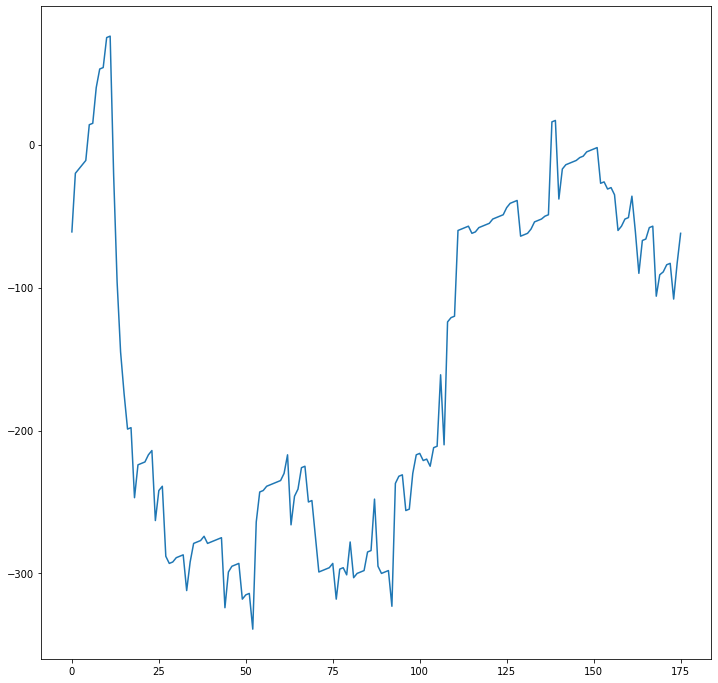

In [81]:
import random
import math
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[[i,j], 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]    
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 10) for i in range(10)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint")#self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: [int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])])(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    fig = plt.figure(figsize=(12, 12))
    plt.plot(list(range(len(self.score))), self.score)
    plt.show()

  def getHint(self):
    prevObjs = sum(1 for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, [0,0]]
    debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix([i,j])
          newScore = sum(sum(self.objects[b][1] - (b == "." or 0) for b in a) for a in newObj.matrix) + (prevObjs - newObj.minDistanceToElement([i,j], ["1", 2]))
          if newScore>tempValues[0]: tempValues = [newScore, [i,j]]
          debugValues[i][j] = newScore
    plt.imshow(debugValues)
    return tempValues[1]
  
  def minDistanceToElement(self, coordinates, elements):
    self.visitedMatrix = [[False]*len(self.matrix[0]) for i in range(len(self.matrix))]
    output = 0
    q = [[coordinates, 0]]
    while q!=[]:
      n = q.pop(0)
      self.visitedMatrix[n[0][0]][n[0][1]] = True
      for i in (lambda l:[j for j in l if j[0]>=0 and j[1]>=0])([[n[0][0]-1, n[0][1]], [n[0][0], n[0][1]+1], [n[0][0]+1, n[0][1]], [n[0][0], n[0][1]-1]]):
        try:
          if not self.visitedMatrix[i[0]][i[1]]: 
            q.append([i, n[1]+1])
            if self.matrix[i[0]][i[1]] in elements: return output
        except:
          pass
      output += 1
    return output    
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(([n[0][0]-1, n[0][1]], [n[0][0], n[0][1]+1], [n[0][0]+1, n[0][1]], [n[0][0], n[0][1]-1])):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    self.visitedMatrix = [[False]*len(self.matrix[0]) for i in range(len(self.matrix))]
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      self.visitedMatrix[n[0]][n[1]] = True
      for i in (lambda l:[j for j in l if j[0]>=0 and j[1]>=0])([[n[0]-1, n[1]], [n[0], n[1]+1], [n[0]+1, n[1]], [n[0], n[1]-1]]):
        try:
          if (not self.visitedMatrix[i[0]][i[1]]) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
        except:
          pass
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()

**Bot Encoding**

In [ ]:
import copy
copyObj = copy.deepcopy(g)

In [ ]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['.', 'b', '1', '2', 'b', '1'],
  ['.', '.', '.', 'a', '3', '.'],
  ['.', '.', 'a', '.', 'c', 'c'],
  ['a', '.', '.', 'a', '.', 'c'],
  ['a', '.', 'a', 'a', '1', '.'],
  ['.', 'a', 'a', 'c', '.', 'b']],
 'seq': '',
 'turn': 9,
 'score': [67, 42, 43, 18, 20, -5, -30, 116, 116, 116, 116, 116, 119, 94],
 'storage': '.',
 'bigFoots': [[[4, 4], 9, False],
  [[0, 2], 9, False],
  [[0, 3], 7, True],
  [[0, 5], 1, False]],
 'actual': 'a',
 'tr': <__main__.Trie at 0x7f2aa84123d0>,
 'visitedMatrix': [[False, False, False, False, False, True],
  [False, False, False, False, False, True],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False]]}

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


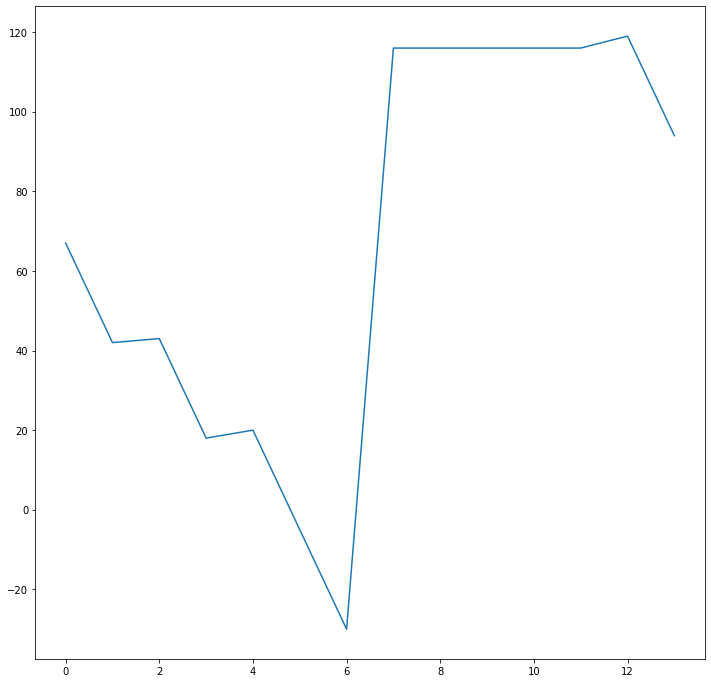

In [ ]:
copyObj.main()